# Data processing

In [1]:
%%capture
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
base_path='/kaggle/input/asl-fingerspelling/'

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np 
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import re
from scipy.stats import skew, kurtosis


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
DEBUG = True

In [4]:
train_path=f'{base_path}/train.csv'
train = pd.read_csv(train_path).head(1000) if DEBUG else pd.read_csv(file_path)
train

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road
...,...,...,...,...,...
995,train_landmarks/5414471.parquet,5414471,1848148361,13,personeel/dplace/
996,train_landmarks/5414471.parquet,5414471,1848157014,56,joelle romero
997,train_landmarks/5414471.parquet,5414471,1848159052,236,alletilbudsaviser.co.no
998,train_landmarks/5414471.parquet,5414471,1848182207,169,https://www.spbuszkowo.pl


In [5]:
train['phrase_char'] = train['phrase'].apply(tuple)
train['phrase_char_len'] = train['phrase_char'].apply(len)

train_sequence_id = train.set_index('sequence_id')

train.head()

,path,file_id,sequence_id,participant_id,phrase,phrase_char,phrase_char_len
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,"(s, c, a, l, e, s, /, k, u, h, a, y, l, a, h)",15
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,"(1, 3, 8, 3, , w, i, l, l, i, a, m, , l, a, ...",19
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,"(9, 8, 8, , f, r, a, n, k, l, i, n, , l, a, ...",17
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,"(6, 9, 2, 0, , n, o, r, t, h, e, a, s, t, , ...",25


In [6]:
with open(base_path+'character_to_prediction_index.json') as json_file:
    CHAR2ORD = json.load(json_file)

CHAR2ORD_df=pd.Series(CHAR2ORD).to_frame('Ordinal Encoding')
print(type(CHAR2ORD),type(CHAR2ORD_df))

N_UNIQUE_CHARACTERS = len(CHAR2ORD)
print(f'CHAR2ORD: {CHAR2ORD}\nN_UNIQUE_CHARACTERS: {N_UNIQUE_CHARACTERS}')

def encode_phrase(phrase):
    # .get(char, -1): if the char doesn't exist in dict, return -1.
    return [CHAR2ORD.get(char, -1) for char in phrase]

train['ordinal_encoding'] = train['phrase'].apply(encode_phrase)

train.head()


<class 'dict'> <class 'pandas.core.frame.DataFrame'>
CHAR2ORD: {' ': 0, '!': 1, '#': 2, '$': 3, '%': 4, '&': 5, "'": 6, '(': 7, ')': 8, '*': 9, '+': 10, ',': 11, '-': 12, '.': 13, '/': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, ';': 26, '=': 27, '?': 28, '@': 29, '[': 30, '_': 31, 'a': 32, 'b': 33, 'c': 34, 'd': 35, 'e': 36, 'f': 37, 'g': 38, 'h': 39, 'i': 40, 'j': 41, 'k': 42, 'l': 43, 'm': 44, 'n': 45, 'o': 46, 'p': 47, 'q': 48, 'r': 49, 's': 50, 't': 51, 'u': 52, 'v': 53, 'w': 54, 'x': 55, 'y': 56, 'z': 57, '~': 58}
N_UNIQUE_CHARACTERS: 59


,path,file_id,sequence_id,participant_id,phrase,phrase_char,phrase_char_len,ordinal_encoding
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12,"[18, 0, 34, 49, 36, 36, 42, 39, 46, 52, 50, 36]"
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,"(s, c, a, l, e, s, /, k, u, h, a, y, l, a, h)",15,"[50, 34, 32, 43, 36, 50, 14, 42, 52, 39, 32, 5..."
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,"(1, 3, 8, 3, , w, i, l, l, i, a, m, , l, a, ...",19,"[16, 18, 23, 18, 0, 54, 40, 43, 43, 40, 32, 44..."
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,"(9, 8, 8, , f, r, a, n, k, l, i, n, , l, a, ...",17,"[24, 23, 23, 0, 37, 49, 32, 45, 42, 43, 40, 45..."
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,"(6, 9, 2, 0, , n, o, r, t, h, e, a, s, t, , ...",25,"[21, 24, 17, 15, 0, 45, 46, 49, 51, 39, 36, 32..."


In [7]:
# Add complete file path to train
def get_file_path(path):
    return f'{base_path}{path}'

train['file_path'] = train['path'].apply(get_file_path)
train.head()

,path,file_id,sequence_id,participant_id,phrase,phrase_char,phrase_char_len,ordinal_encoding,file_path
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12,"[18, 0, 34, 49, 36, 36, 42, 39, 46, 52, 50, 36]",/kaggle/input/asl-fingerspelling/train_landmar...
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,"(s, c, a, l, e, s, /, k, u, h, a, y, l, a, h)",15,"[50, 34, 32, 43, 36, 50, 14, 42, 52, 39, 32, 5...",/kaggle/input/asl-fingerspelling/train_landmar...
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,"(1, 3, 8, 3, , w, i, l, l, i, a, m, , l, a, ...",19,"[16, 18, 23, 18, 0, 54, 40, 43, 43, 40, 32, 44...",/kaggle/input/asl-fingerspelling/train_landmar...
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,"(9, 8, 8, , f, r, a, n, k, l, i, n, , l, a, ...",17,"[24, 23, 23, 0, 37, 49, 32, 45, 42, 43, 40, 45...",/kaggle/input/asl-fingerspelling/train_landmar...
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,"(6, 9, 2, 0, , n, o, r, t, h, e, a, s, t, , ...",25,"[21, 24, 17, 15, 0, 45, 46, 49, 51, 39, 36, 32...",/kaggle/input/asl-fingerspelling/train_landmar...


In [8]:
# Add phrase_type col
def get_phrase_type(phrase):
    if re.match(r'^[\d+-]+$', phrase):
        return 'phone_number'
    elif any([substr in phrase for substr in ['www', '.', '/']]) and ' ' not in phrase:
        return 'url'
    else:
        return 'address'
    
train['phrase_type'] = train['phrase'].apply(get_phrase_type)
train.head()

,path,file_id,sequence_id,participant_id,phrase,phrase_char,phrase_char_len,ordinal_encoding,file_path,phrase_type
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12,"[18, 0, 34, 49, 36, 36, 42, 39, 46, 52, 50, 36]",/kaggle/input/asl-fingerspelling/train_landmar...,address
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,"(s, c, a, l, e, s, /, k, u, h, a, y, l, a, h)",15,"[50, 34, 32, 43, 36, 50, 14, 42, 52, 39, 32, 5...",/kaggle/input/asl-fingerspelling/train_landmar...,url
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,"(1, 3, 8, 3, , w, i, l, l, i, a, m, , l, a, ...",19,"[16, 18, 23, 18, 0, 54, 40, 43, 43, 40, 32, 44...",/kaggle/input/asl-fingerspelling/train_landmar...,address
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,"(9, 8, 8, , f, r, a, n, k, l, i, n, , l, a, ...",17,"[24, 23, 23, 0, 37, 49, 32, 45, 42, 43, 40, 45...",/kaggle/input/asl-fingerspelling/train_landmar...,address
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,"(6, 9, 2, 0, , n, o, r, t, h, e, a, s, t, , ...",25,"[21, 24, 17, 15, 0, 45, 46, 49, 51, 39, 36, 32...",/kaggle/input/asl-fingerspelling/train_landmar...,address


# Deal with landmarks files

In [9]:
def get_col_with_NaN(dataframe):
    has_nan = dataframe.isna().any()
    cols_with_nan = has_nan[has_nan].index.tolist()
    print(len(list(dataframe.iterrows())),',',len(cols_with_nan))
    print("Columns with NaN values:", cols_with_nan)
    
#get_col_with_NaN(pd.read_parquet(train['file_path'][0]))

In [10]:
%%time
def process_landmarks(file_path,sequence_id, debug=False):
    landmarks = pd.read_parquet(file_path)
    landmarks = landmarks.loc[landmarks.index == seq_id]
#     print(landmarks)
#     return
    
    hand_cols_without_z = [col for col in landmarks.columns if ('left_hand' in col or 'right_hand' in col) and not col.startswith('z_')]
    landmarks = landmarks[['frame']+hand_cols_without_z]

    landmarks['sequence_id'] = sequence_id

    # Deal with NaN  (*problem: not sure which way to fill NaN is better)
    coordinate_cols = [col for col in landmarks.columns if col.startswith(('x_', 'y_'))]
    landmarks.loc[:, coordinate_cols] = landmarks[coordinate_cols].fillna(0.0)
    
    # Others..unfinished....
    # ...

    return landmarks


#processed_landmarks_list = [process_landmarks(file_path, debug=DEBUG) for file_path in tqdm(train['file_path'])]
processed_landmarks_list = []
for file_path, seq_id in tqdm(zip(train['file_path'], train['sequence_id'])):
    processed_landmarks = process_landmarks(file_path, seq_id, debug=DEBUG)
    processed_landmarks_list.append(processed_landmarks)
    
all_processed_landmarks = pd.concat(processed_landmarks_list, ignore_index=True)

0it [00:00, ?it/s]

CPU times: user 1h 3min 51s, sys: 34min 51s, total: 1h 38min 43s
Wall time: 56min 33s


In [11]:
all_processed_landmarks.head()

,frame,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,x_left_hand_7,x_left_hand_8,...,y_right_hand_12,y_right_hand_13,y_right_hand_14,y_right_hand_15,y_right_hand_16,y_right_hand_17,y_right_hand_18,y_right_hand_19,y_right_hand_20,sequence_id
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.439064,0.680148,0.645134,0.697051,0.739250,0.728379,0.730378,0.770165,0.798621,1816796431
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1816796431
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1816796431
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.493427,0.667076,0.677703,0.737446,0.783664,0.706994,0.722034,0.768912,0.799930,1816796431
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1816796431


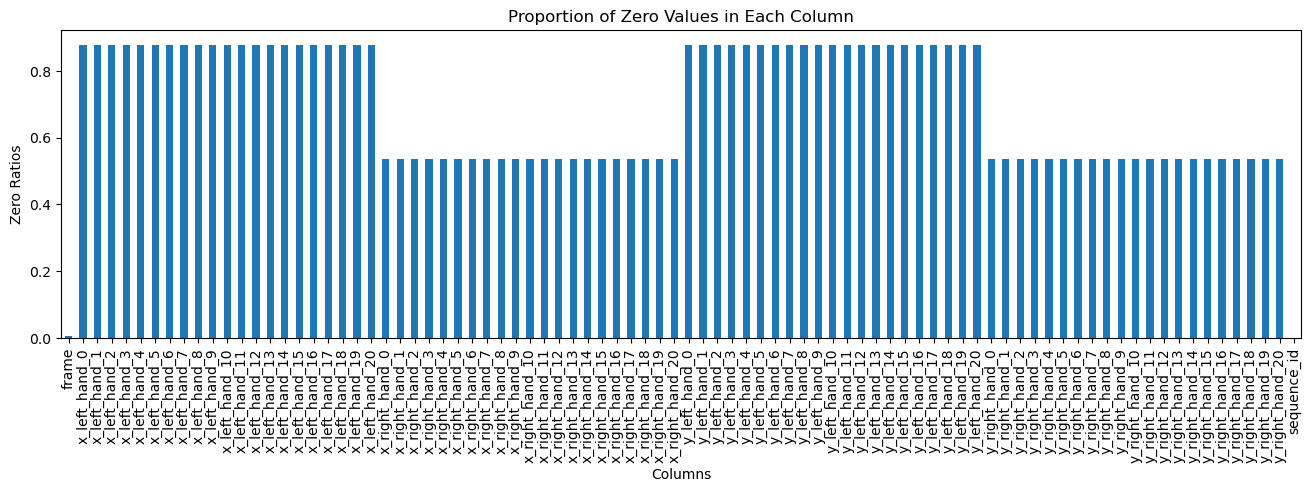

frame              0.006140
x_left_hand_0      0.878053
x_left_hand_1      0.878053
x_left_hand_2      0.878053
x_left_hand_3      0.878053
                     ...   
y_right_hand_17    0.534507
y_right_hand_18    0.534507
y_right_hand_19    0.534507
y_right_hand_20    0.534507
sequence_id        0.000000
Length: 86, dtype: float64

In [12]:
def zero_ratios_each_col(dataframe,IF_PLT=False):
    zero_ratios = (dataframe == 0).mean()

    if IF_PLT:
        plt.figure(figsize=(16, 4))
        zero_ratios.plot(kind='bar')
        plt.xlabel('Columns')
        plt.ylabel('Zero Ratios')
        plt.title('Proportion of Zero Values in Each Column')
        plt.show()

    return zero_ratios

zero_ratios_each_col(all_processed_landmarks,True)


In [13]:
# Get all kind of body part in landmarks
cols = all_processed_landmarks.columns

parts = set()

for col in cols:
    if '_' in col:
        part_name = '_'.join(col.split('_')[1:-1])
        if len(part_name)>0:
            parts.add(part_name)

parts_list = list(parts)
print(parts_list)

['left_hand', 'right_hand']


In [14]:
# %%time
# final_coordinates_list = []

# for row_index, frame in tqdm(all_processed_landmarks.iterrows()):
# #     if DEBUG and len(final_coordinates_list) >= 1000:
# #         break
#     for part_name in parts_list:
#         max_index = max(int(col.split('_')[-1]) for col in cols if f'x_{part_name}_' in col)
#         for index in range(max_index + 1):
#             temp_coordinates = {
#                 'sequence_id': int(frame['sequence_id']),
#                 'frame': int(frame['frame']),
#                 'part': part_name,
#                 'index': index,
#                 'x': frame[f'x_{part_name}_{index}'],
#                 'y': frame[f'y_{part_name}_{index}'],
#                 'z': frame[f'z_{part_name}_{index}'],
#             }
#             final_coordinates_list.append(temp_coordinates)

# new_df = pd.DataFrame(final_coordinates_list)

In [15]:
# # Just want to try--
# # Set MultiIndex
# new_df.set_index(['part', 'index'], inplace=True)

# print(new_df.loc[('right_hand', 20)])
# print(new_df.loc[('pose')].head())
# new_df.tail()

# new_df.reset_index(inplace=True)

In [16]:
# merged_df = pd.merge(train, new_df, on='sequence_id', how='left')

# #merged_df.query("part=='pose'")
# merged_df

# Merge Train and Landmarks

In [17]:
merged_df = pd.merge(train, all_processed_landmarks, on='sequence_id', how='left')

#print(', '.join(merged_df.columns))
merged_df.info()
merged_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162866 entries, 0 to 162865
Data columns (total 95 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   path              162866 non-null  object 
 1   file_id           162866 non-null  int64  
 2   sequence_id       162866 non-null  int64  
 3   participant_id    162866 non-null  int64  
 4   phrase            162866 non-null  object 
 5   phrase_char       162866 non-null  object 
 6   phrase_char_len   162866 non-null  int64  
 7   ordinal_encoding  162866 non-null  object 
 8   file_path         162866 non-null  object 
 9   phrase_type       162866 non-null  object 
 10  frame             162866 non-null  int16  
 11  x_left_hand_0     162866 non-null  float32
 12  x_left_hand_1     162866 non-null  float32
 13  x_left_hand_2     162866 non-null  float32
 14  x_left_hand_3     162866 non-null  float32
 15  x_left_hand_4     162866 non-null  float32
 16  x_left_hand_5     16

,path,file_id,sequence_id,participant_id,phrase,phrase_char,phrase_char_len,ordinal_encoding,file_path,phrase_type,...,y_right_hand_11,y_right_hand_12,y_right_hand_13,y_right_hand_14,y_right_hand_15,y_right_hand_16,y_right_hand_17,y_right_hand_18,y_right_hand_19,y_right_hand_20
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12,"[18, 0, 34, 49, 36, 36, 42, 39, 46, 52, 50, 36]",/kaggle/input/asl-fingerspelling/train_landmar...,address,...,0.490615,0.439064,0.680148,0.645134,0.697051,0.739250,0.728379,0.730378,0.770165,0.798621
1,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12,"[18, 0, 34, 49, 36, 36, 42, 39, 46, 52, 50, 36]",/kaggle/input/asl-fingerspelling/train_landmar...,address,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12,"[18, 0, 34, 49, 36, 36, 42, 39, 46, 52, 50, 36]",/kaggle/input/asl-fingerspelling/train_landmar...,address,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12,"[18, 0, 34, 49, 36, 36, 42, 39, 46, 52, 50, 36]",/kaggle/input/asl-fingerspelling/train_landmar...,address,...,0.528952,0.493427,0.667076,0.677703,0.737446,0.783664,0.706994,0.722034,0.768912,0.799930
4,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12,"[18, 0, 34, 49, 36, 36, 42, 39, 46, 52, 50, 36]",/kaggle/input/asl-fingerspelling/train_landmar...,address,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162861,train_landmarks/105143404.parquet,105143404,1784552841,188,https://www.xn--pearol-xwa.org,"(h, t, t, p, s, :, /, /, w, w, w, ., x, n, -, ...",30,"[39, 51, 51, 47, 50, 25, 14, 14, 54, 54, 54, 1...",/kaggle/input/asl-fingerspelling/train_landmar...,url,...,0.506176,0.516161,0.526192,0.507983,0.529134,0.538894,0.551234,0.538749,0.553798,0.560894
162862,train_landmarks/105143404.parquet,105143404,1784552841,188,https://www.xn--pearol-xwa.org,"(h, t, t, p, s, :, /, /, w, w, w, ., x, n, -, ...",30,"[39, 51, 51, 47, 50, 25, 14, 14, 54, 54, 54, 1...",/kaggle/input/asl-fingerspelling/train_landmar...,url,...,0.511583,0.523036,0.536033,0.515789,0.536600,0.547010,0.561565,0.547057,0.560887,0.567938
162863,train_landmarks/105143404.parquet,105143404,1784552841,188,https://www.xn--pearol-xwa.org,"(h, t, t, p, s, :, /, /, w, w, w, ., x, n, -, ...",30,"[39, 51, 51, 47, 50, 25, 14, 14, 54, 54, 54, 1...",/kaggle/input/asl-fingerspelling/train_landmar...,url,...,0.526760,0.541187,0.548823,0.530709,0.554415,0.565096,0.578240,0.564837,0.579378,0.585581
162864,train_landmarks/105143404.parquet,105143404,1784552841,188,https://www.xn--pearol-xwa.org,"(h, t, t, p, s, :, /, /, w, w, w, ., x, n, -, ...",30,"[39, 51, 51, 47, 50, 25, 14, 14, 54, 54, 54, 1...",/kaggle/input/asl-fingerspelling/train_landmar...,url,...,0.550151,0.567674,0.568473,0.553857,0.580056,0.591092,0.601379,0.589957,0.606761,0.614663


In [18]:
get_col_with_NaN(merged_df)

162866 , 0
Columns with NaN values: []


In [19]:
# Feature cols
features = merged_df.drop(columns=['ordinal_encoding','path','file_id','sequence_id','participant_id','phrase','phrase_char','file_path'])

# Label cols
labels = merged_df['ordinal_encoding']


features.shape,labels.shape
features

,phrase_char_len,phrase_type,frame,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,...,y_right_hand_11,y_right_hand_12,y_right_hand_13,y_right_hand_14,y_right_hand_15,y_right_hand_16,y_right_hand_17,y_right_hand_18,y_right_hand_19,y_right_hand_20
0,12,address,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.490615,0.439064,0.680148,0.645134,0.697051,0.739250,0.728379,0.730378,0.770165,0.798621
1,12,address,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,12,address,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,12,address,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.528952,0.493427,0.667076,0.677703,0.737446,0.783664,0.706994,0.722034,0.768912,0.799930
4,12,address,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162861,30,url,289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.506176,0.516161,0.526192,0.507983,0.529134,0.538894,0.551234,0.538749,0.553798,0.560894
162862,30,url,290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.511583,0.523036,0.536033,0.515789,0.536600,0.547010,0.561565,0.547057,0.560887,0.567938
162863,30,url,291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.526760,0.541187,0.548823,0.530709,0.554415,0.565096,0.578240,0.564837,0.579378,0.585581
162864,30,url,292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.550151,0.567674,0.568473,0.553857,0.580056,0.591092,0.601379,0.589957,0.606761,0.614663


In [20]:
print(', '.join(features.columns))

phrase_char_len, phrase_type, frame, x_left_hand_0, x_left_hand_1, x_left_hand_2, x_left_hand_3, x_left_hand_4, x_left_hand_5, x_left_hand_6, x_left_hand_7, x_left_hand_8, x_left_hand_9, x_left_hand_10, x_left_hand_11, x_left_hand_12, x_left_hand_13, x_left_hand_14, x_left_hand_15, x_left_hand_16, x_left_hand_17, x_left_hand_18, x_left_hand_19, x_left_hand_20, x_right_hand_0, x_right_hand_1, x_right_hand_2, x_right_hand_3, x_right_hand_4, x_right_hand_5, x_right_hand_6, x_right_hand_7, x_right_hand_8, x_right_hand_9, x_right_hand_10, x_right_hand_11, x_right_hand_12, x_right_hand_13, x_right_hand_14, x_right_hand_15, x_right_hand_16, x_right_hand_17, x_right_hand_18, x_right_hand_19, x_right_hand_20, y_left_hand_0, y_left_hand_1, y_left_hand_2, y_left_hand_3, y_left_hand_4, y_left_hand_5, y_left_hand_6, y_left_hand_7, y_left_hand_8, y_left_hand_9, y_left_hand_10, y_left_hand_11, y_left_hand_12, y_left_hand_13, y_left_hand_14, y_left_hand_15, y_left_hand_16, y_left_hand_17, y_left_hand_

In [21]:
zero_ratios=zero_ratios_each_col(features)
zero_ratios.max()

0.8780531234266207

In [22]:
def remove_zero_cols(data,ratio=1.0):
    zero_ratios = (data == 0).mean()
    cols_to_remove = zero_ratios[zero_ratios >= ratio].index
    return data.drop(columns=cols_to_remove)

features_without_zero_cols = remove_zero_cols(features,1.0)
zero_ratios_each_col(features_without_zero_cols).info()

<class 'pandas.core.series.Series'>
Index: 87 entries, phrase_char_len to y_right_hand_20
Series name: None
Non-Null Count  Dtype  
--------------  -----  
87 non-null     float64
dtypes: float64(1)
memory usage: 1.4+ KB


In [23]:
features=features_without_zero_cols
features

,phrase_char_len,phrase_type,frame,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,...,y_right_hand_11,y_right_hand_12,y_right_hand_13,y_right_hand_14,y_right_hand_15,y_right_hand_16,y_right_hand_17,y_right_hand_18,y_right_hand_19,y_right_hand_20
0,12,address,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.490615,0.439064,0.680148,0.645134,0.697051,0.739250,0.728379,0.730378,0.770165,0.798621
1,12,address,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,12,address,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,12,address,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.528952,0.493427,0.667076,0.677703,0.737446,0.783664,0.706994,0.722034,0.768912,0.799930
4,12,address,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162861,30,url,289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.506176,0.516161,0.526192,0.507983,0.529134,0.538894,0.551234,0.538749,0.553798,0.560894
162862,30,url,290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.511583,0.523036,0.536033,0.515789,0.536600,0.547010,0.561565,0.547057,0.560887,0.567938
162863,30,url,291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.526760,0.541187,0.548823,0.530709,0.554415,0.565096,0.578240,0.564837,0.579378,0.585581
162864,30,url,292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.550151,0.567674,0.568473,0.553857,0.580056,0.591092,0.601379,0.589957,0.606761,0.614663


# Continue to process dataset

In [24]:
from sklearn.preprocessing import OneHotEncoder

def do_OneHotEncoder(data, col):
    encoder = OneHotEncoder(sparse_output=False)

    phrase_type = data[col].values.reshape(-1, 1)

    phrase_type_onehot = encoder.fit_transform(phrase_type)
    phrase_type_onehot_df = pd.DataFrame(phrase_type_onehot, columns=encoder.get_feature_names_out(['phrase_type']))

    data = data.drop(columns=[col])
    data = pd.concat([data.reset_index(drop=True), phrase_type_onehot_df], axis=1)

    return data
    
features=do_OneHotEncoder(features,'phrase_type')
features.head()

,phrase_char_len,frame,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,x_left_hand_7,...,y_right_hand_14,y_right_hand_15,y_right_hand_16,y_right_hand_17,y_right_hand_18,y_right_hand_19,y_right_hand_20,phrase_type_address,phrase_type_phone_number,phrase_type_url
0,12,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.645134,0.697051,0.739250,0.728379,0.730378,0.770165,0.798621,1.0,0.0,0.0
1,12,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0
2,12,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0
3,12,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.677703,0.737446,0.783664,0.706994,0.722034,0.768912,0.799930,1.0,0.0,0.0
4,12,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0


In [25]:
features

,phrase_char_len,frame,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,x_left_hand_7,...,y_right_hand_14,y_right_hand_15,y_right_hand_16,y_right_hand_17,y_right_hand_18,y_right_hand_19,y_right_hand_20,phrase_type_address,phrase_type_phone_number,phrase_type_url
0,12,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.645134,0.697051,0.739250,0.728379,0.730378,0.770165,0.798621,1.0,0.0,0.0
1,12,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0
2,12,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0
3,12,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.677703,0.737446,0.783664,0.706994,0.722034,0.768912,0.799930,1.0,0.0,0.0
4,12,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162861,30,289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.507983,0.529134,0.538894,0.551234,0.538749,0.553798,0.560894,0.0,0.0,1.0
162862,30,290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.515789,0.536600,0.547010,0.561565,0.547057,0.560887,0.567938,0.0,0.0,1.0
162863,30,291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.530709,0.554415,0.565096,0.578240,0.564837,0.579378,0.585581,0.0,0.0,1.0
162864,30,292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.553857,0.580056,0.591092,0.601379,0.589957,0.606761,0.614663,0.0,0.0,1.0


In [26]:
def find_cols_maybe_need_to_normalize(data):
    cols_to_normalize = []
    numerical_cols = data.select_dtypes(include=np.number).columns
    for col in numerical_cols:
        min_val = data[col].min()
        max_val = data[col].max()
        if min_val < 0 or max_val > 1:
            cols_to_normalize.append(col)
    return cols_to_normalize

cols_to_normalize=find_cols_maybe_need_to_normalize(features)
print(cols_to_normalize)

['phrase_char_len', 'frame', 'x_left_hand_0', 'x_left_hand_1', 'x_left_hand_6', 'x_left_hand_7', 'x_left_hand_8', 'x_left_hand_10', 'x_left_hand_11', 'x_left_hand_12', 'x_left_hand_14', 'x_left_hand_15', 'x_left_hand_16', 'x_left_hand_17', 'x_left_hand_18', 'x_left_hand_19', 'x_left_hand_20', 'x_right_hand_0', 'x_right_hand_1', 'x_right_hand_2', 'x_right_hand_4', 'x_right_hand_7', 'x_right_hand_8', 'x_right_hand_9', 'x_right_hand_11', 'x_right_hand_12', 'x_right_hand_13', 'x_right_hand_14', 'x_right_hand_15', 'x_right_hand_16', 'x_right_hand_17', 'x_right_hand_18', 'x_right_hand_19', 'x_right_hand_20', 'y_left_hand_0', 'y_left_hand_1', 'y_left_hand_3', 'y_left_hand_4', 'y_left_hand_6', 'y_left_hand_7', 'y_left_hand_8', 'y_left_hand_10', 'y_left_hand_11', 'y_left_hand_12', 'y_left_hand_13', 'y_left_hand_14', 'y_left_hand_15', 'y_left_hand_16', 'y_left_hand_17', 'y_left_hand_18', 'y_left_hand_19', 'y_left_hand_20', 'y_right_hand_0', 'y_right_hand_1', 'y_right_hand_2', 'y_right_hand_3', '

In [27]:
cols_to_normalize.remove('frame')
print(cols_to_normalize)

['phrase_char_len', 'x_left_hand_0', 'x_left_hand_1', 'x_left_hand_6', 'x_left_hand_7', 'x_left_hand_8', 'x_left_hand_10', 'x_left_hand_11', 'x_left_hand_12', 'x_left_hand_14', 'x_left_hand_15', 'x_left_hand_16', 'x_left_hand_17', 'x_left_hand_18', 'x_left_hand_19', 'x_left_hand_20', 'x_right_hand_0', 'x_right_hand_1', 'x_right_hand_2', 'x_right_hand_4', 'x_right_hand_7', 'x_right_hand_8', 'x_right_hand_9', 'x_right_hand_11', 'x_right_hand_12', 'x_right_hand_13', 'x_right_hand_14', 'x_right_hand_15', 'x_right_hand_16', 'x_right_hand_17', 'x_right_hand_18', 'x_right_hand_19', 'x_right_hand_20', 'y_left_hand_0', 'y_left_hand_1', 'y_left_hand_3', 'y_left_hand_4', 'y_left_hand_6', 'y_left_hand_7', 'y_left_hand_8', 'y_left_hand_10', 'y_left_hand_11', 'y_left_hand_12', 'y_left_hand_13', 'y_left_hand_14', 'y_left_hand_15', 'y_left_hand_16', 'y_left_hand_17', 'y_left_hand_18', 'y_left_hand_19', 'y_left_hand_20', 'y_right_hand_0', 'y_right_hand_1', 'y_right_hand_2', 'y_right_hand_3', 'y_right_h

In [28]:
from sklearn.preprocessing import MinMaxScaler

# Normalize dataset
def normalize_cols(data,cols_to_normalize):
    scaler = MinMaxScaler()
    
    data[cols_to_normalize] = scaler.fit_transform(data[cols_to_normalize])
    return data
normalize_cols(features,cols_to_normalize)
features

,phrase_char_len,frame,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,x_left_hand_7,...,y_right_hand_14,y_right_hand_15,y_right_hand_16,y_right_hand_17,y_right_hand_18,y_right_hand_19,y_right_hand_20,phrase_type_address,phrase_type_phone_number,phrase_type_url
0,0.296296,0,0.0,0.0,0.0,0.0,0.0,0.0,0.009393,0.075106,...,0.609251,0.658686,0.682895,0.689896,0.688420,0.725634,0.738798,1.0,0.0,0.0
1,0.296296,1,0.0,0.0,0.0,0.0,0.0,0.0,0.009393,0.075106,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0
2,0.296296,2,0.0,0.0,0.0,0.0,0.0,0.0,0.009393,0.075106,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0
3,0.296296,3,0.0,0.0,0.0,0.0,0.0,0.0,0.009393,0.075106,...,0.640008,0.696858,0.723924,0.669641,0.680556,0.724454,0.740010,1.0,0.0,0.0
4,0.296296,4,0.0,0.0,0.0,0.0,0.0,0.0,0.009393,0.075106,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162861,0.962963,289,0.0,0.0,0.0,0.0,0.0,0.0,0.009393,0.075106,...,0.479728,0.500011,0.497813,0.522110,0.507800,0.521778,0.518879,0.0,0.0,1.0
162862,0.962963,290,0.0,0.0,0.0,0.0,0.0,0.0,0.009393,0.075106,...,0.487100,0.507066,0.505311,0.531896,0.515630,0.528457,0.525396,0.0,0.0,1.0
162863,0.962963,291,0.0,0.0,0.0,0.0,0.0,0.0,0.009393,0.075106,...,0.501190,0.523900,0.522018,0.547689,0.532389,0.545879,0.541717,0.0,0.0,1.0
162864,0.962963,292,0.0,0.0,0.0,0.0,0.0,0.0,0.009393,0.075106,...,0.523050,0.548130,0.546032,0.569606,0.556066,0.571678,0.568621,0.0,0.0,1.0


In [29]:
features['phrase_char_len'].min()

0.0

In [30]:
features_save=features.copy()
# features=features_save.copy()
labels_save=labels.copy()
# labels_save

In [31]:
type(labels)

pandas.core.series.Series

In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

ordinal_encoding = labels.tolist()

padded_sequences_labels = pad_sequences(ordinal_encoding, padding='post')

labels = np.array(padded_sequences_labels)
labels

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

array([[18,  0, 34, ...,  0,  0,  0],
       [18,  0, 34, ...,  0,  0,  0],
       [18,  0, 34, ...,  0,  0,  0],
       ...,
       [39, 51, 51, ..., 49, 38,  0],
       [39, 51, 51, ..., 49, 38,  0],
       [39, 51, 51, ..., 49, 38,  0]], dtype=int32)

# Train model 1 -- Transformer

https://www.tensorflow.org/text/tutorials/transformer

In [33]:
VOCAB_SIZE = N_UNIQUE_CHARACTERS
NUM_LAYERS = 4
UNITS = 512
D_MODEL = 128
NUM_HEADS = 8
DROPOUT = 0.1
EPOCHS = 10
BATCH_SIZE = 64

In [34]:
import logging
import time

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

In [35]:
X=features.copy()
y=labels.copy()
type(X),type(y)

(pandas.core.frame.DataFrame, numpy.ndarray)

In [36]:
X=X.values
type(X)

numpy.ndarray

In [38]:
from sklearn.utils import shuffle

X,y=shuffle(X,y)
X,y

(array([[6.66666667e-01, 8.50000000e+01, 0.00000000e+00, ...,
         0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
        [7.03703704e-01, 8.10000000e+01, 0.00000000e+00, ...,
         1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.96296296e-01, 6.40000000e+01, 0.00000000e+00, ...,
         0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
        ...,
        [7.77777778e-01, 5.83000000e+02, 7.46710544e-01, ...,
         0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
        [6.66666667e-01, 1.94000000e+02, 0.00000000e+00, ...,
         0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
        [3.33333333e-01, 3.90000000e+01, 0.00000000e+00, ...,
         0.00000000e+00, 1.00000000e+00, 0.00000000e+00]]),
 array([[10, 24, 22, ...,  0,  0,  0],
        [16, 18, 24, ...,  0,  0,  0],
        [18, 16, 15, ...,  0,  0,  0],
        ...,
        [39, 51, 51, ...,  0,  0,  0],
        [10, 17, 16, ...,  0,  0,  0],
        [10, 22, 12, ...,  0,  0,  0]], dtype=int32))

In [39]:
# Split train val sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [40]:
# from_tensor_slices: https://note.com/mlai/n/n64ca144365ac
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
train_dataset,val_dataset

(<_TensorSliceDataset element_spec=(TensorSpec(shape=(89,), dtype=tf.float64, name=None), TensorSpec(shape=(31,), dtype=tf.int32, name=None))>,
 <_TensorSliceDataset element_spec=(TensorSpec(shape=(89,), dtype=tf.float64, name=None), TensorSpec(shape=(31,), dtype=tf.int32, name=None))>)

In [41]:
# Shuffle and batch the datasets 
train_batches = train_dataset.shuffle(10000).batch(BATCH_SIZE)
val_batches = val_dataset.batch(BATCH_SIZE)  #* No need to shuffle validation data 
'''* It will show 'shape=(None, 89)' here because TensorFlow won't know the size without 
     using .take() and check the size inside it 
'''
train_batches,val_batches

(<_BatchDataset element_spec=(TensorSpec(shape=(None, 89), dtype=tf.float64, name=None), TensorSpec(shape=(None, 31), dtype=tf.int32, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 89), dtype=tf.float64, name=None), TensorSpec(shape=(None, 31), dtype=tf.int32, name=None))>)

In [42]:
# The difference before and after using .batch() 
for X, y in train_dataset.take(1):  # Take n samples
    print('X shape: ',X.shape,'y shape: ',y.shape)
#     print("X:", X.numpy())
#     print("Y:", y.numpy())
for X_batch, y_batch in train_batches.take(1):
    print('X_batch shape: ',X_batch.shape,'y_batch shape: ',y_batch.shape)  
#   print("X:", X_batch)
#   print("Y:", y_batch) 
    print(X_batch[0][:10])
    print(y_batch[0][:10])


X shape:  (89,) y shape:  (31,)
X_batch shape:  (64, 89) y_batch shape:  (64, 31)
tf.Tensor(
[8.14814815e-01 1.36000000e+02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.39308935e-03 7.51060843e-02], shape=(10,), dtype=float64)
tf.Tensor([49 36 53 40 50 51 32 46 49 50], shape=(10,), dtype=int32)


In [43]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

(2048, 512)


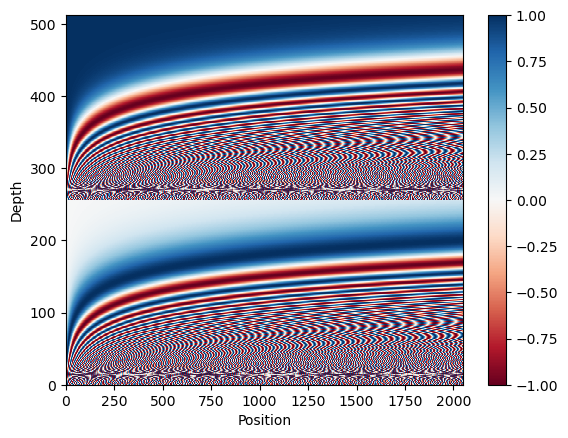

In [44]:
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

(0.0, 1.0)

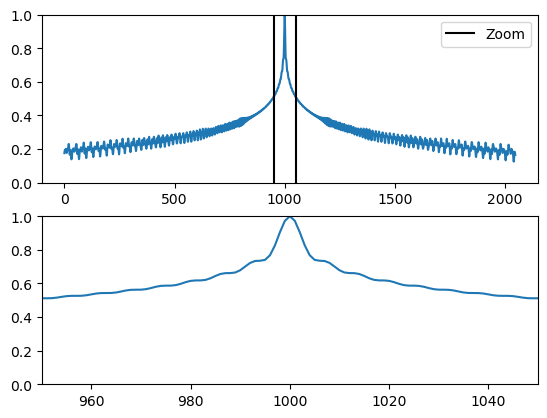

In [45]:
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])

In [46]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [47]:
embed_X = PositionalEmbedding(vocab_size=N_UNIQUE_CHARACTERS, d_model=512)
embed_y = PositionalEmbedding(vocab_size=N_UNIQUE_CHARACTERS, d_model=512)

X_emb = embed_X(X_batch)
y_emb = embed_y(y_batch)
X_emb,y_emb

(<tf.Tensor: shape=(64, 89, 512), dtype=float32, numpy=
 array([[[-1.7908111e-01, -7.8220797e-01,  6.8751365e-01, ...,
           8.7188596e-01,  2.1045346e+00,  1.8191204e+00],
         [ 8.4147096e-01,  8.2185620e-01,  8.0196178e-01, ...,
           1.0000000e+00,  1.0000000e+00,  1.0000000e+00],
         [ 7.3021626e-01,  1.5420675e-01,  1.6456580e+00, ...,
           8.7188596e-01,  2.1045346e+00,  1.8191204e+00],
         ...,
         [-1.1025395e+00,  1.7566162e-01, -3.0917382e-01, ...,
           8.7184006e-01,  2.1044922e+00,  1.8190806e+00],
         [-1.0008990e+00, -4.7451258e-04,  2.6895821e-02, ...,
           8.7183899e-01,  2.1044910e+00,  1.8190796e+00],
         [ 1.9368753e-01,  9.4778717e-01, -4.5162141e-02, ...,
          -6.2793255e-02,  1.1224957e+00,  5.5522084e-01]],
 
        [[-1.7908111e-01, -7.8220797e-01,  6.8751365e-01, ...,
           8.7188596e-01,  2.1045346e+00,  1.8191204e+00],
         [ 6.9821131e-01,  4.8830688e-02,  8.7212163e-01, ...,
          

In [48]:
X_emb._keras_mask

<tf.Tensor: shape=(64, 89), dtype=bool, numpy=
array([[ True,  True, False, ..., False, False,  True],
       [ True,  True, False, ..., False,  True, False],
       [ True,  True, False, ...,  True, False, False],
       ...,
       [ True,  True, False, ...,  True, False, False],
       [ True,  True, False, ..., False, False,  True],
       [ True,  True, False, ...,  True, False, False]])>

In [49]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [50]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [51]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(X_emb.shape)
print(y_emb.shape)
print(sample_ca(y_emb, X_emb).shape)

(64, 89, 512)
(64, 31, 512)
(64, 31, 512)


In [52]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [53]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(X_emb.shape)
print(sample_gsa(X_emb).shape)

(64, 89, 512)
(64, 89, 512)


In [54]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [55]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(y_emb.shape)
print(sample_csa(y_emb).shape)

(64, 31, 512)
(64, 31, 512)


In [56]:
out1 = sample_csa(embed_y(y_batch[:, :3])) 
out2 = sample_csa(embed_y(y_batch))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

0.13356906

In [57]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

In [58]:
sample_ffn = FeedForward(512, 2048)

print(y_emb.shape)
print(sample_ffn(y_emb).shape)

(64, 31, 512)
(64, 31, 512)


In [59]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [60]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(X_emb.shape)
print(sample_encoder_layer(X_emb).shape)

(64, 89, 512)
(64, 89, 512)


In [61]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [62]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(X_batch, training=False)

# Print the shape.
print(X_batch.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 89)
(64, 89, 512)


In [63]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [64]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=y_emb, context=X_emb)

print(y_emb.shape)
print(X_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 31, 512)
(64, 89, 512)
(64, 31, 512)


In [65]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [66]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=y_batch,
    context=X_emb)

# Print the shapes.
print(y_batch.shape)
print(X_emb.shape)
print(output.shape)

(64, 31)
(64, 89, 512)
(64, 31, 512)


In [67]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 31, 89])

In [68]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [69]:
# Hyper parameters
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [70]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=N_UNIQUE_CHARACTERS,
    target_vocab_size=N_UNIQUE_CHARACTERS,
    dropout_rate=dropout_rate)

In [71]:
output = transformer((X_batch, y_batch))

print(X_batch.shape)
print(y_batch.shape)
print(output.shape)

(64, 89)
(64, 31)
(64, 31, 59)


In [72]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 31, 89)


In [73]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  2646400   
                                                                 
 decoder_1 (Decoder)         multiple                  4757376   
                                                                 
 dense_38 (Dense)            multiple                  7611      
                                                                 
Total params: 7,411,387
Trainable params: 7,411,387
Non-trainable params: 0
_________________________________________________________________


In [74]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [75]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
optimizer

Text(0.5, 0, 'Train Step')

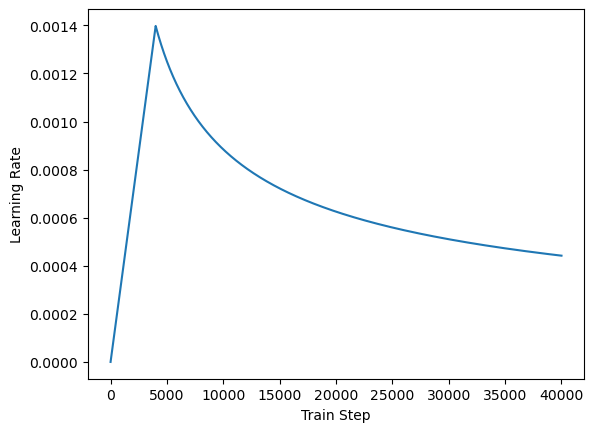

In [76]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [77]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [78]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [79]:
def restructure_inputs(context, x):
    context = tf.cast(context, tf.float32)  
    x = tf.cast(x, tf.float32)  
    return (context, x), x

restructure_train_batches = train_batches.map(restructure_inputs)
restructure_val_batches = val_batches.map(restructure_inputs)


In [ ]:
%%time
transformer.fit(restructure_train_batches,
                epochs=20,
                validation_data=restructure_val_batches)

Epoch 1/20
2036/2036 [==============================] - 374s 164ms/step - loss: 0.2123 - masked_accuracy: 0.9559 - val_loss: 2.3468e-11 - val_masked_accuracy: 1.0000
Epoch 2/20
2036/2036 [==============================] - 344s 169ms/step - loss: 0.0515 - masked_accuracy: 0.9954 - val_loss: 0.0520 - val_masked_accuracy: 0.9967
Epoch 3/20
2036/2036 [==============================] - 343s 168ms/step - loss: 0.0054 - masked_accuracy: 0.9990 - val_loss: 4.0762e-04 - val_masked_accuracy: 0.9999
Epoch 4/20
2036/2036 [==============================] - 331s 163ms/step - loss: 0.0020 - masked_accuracy: 0.9996 - val_loss: 9.5699e-06 - val_masked_accuracy: 1.0000
Epoch 5/20
2036/2036 [==============================] - 343s 168ms/step - loss: 0.0013 - masked_accuracy: 0.9998 - val_loss: 4.3955e-05 - val_masked_accuracy: 1.0000
Epoch 6/20
2036/2036 [==============================] - 345s 170ms/step - loss: 0.0010 - masked_accuracy: 0.9998 - val_loss: 1.2863e-05 - val_masked_accuracy: 1.0000
Epoch 7/

In [ ]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [ ]:
translator = Translator(tokenizers, transformer)

In [ ]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
sentence = ''
ground_truth = ''

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

In [ ]:
# !apt install --allow-change-held-packages libcudnn8="8.4.0.27-1+cuda11.6"
# !pip install --upgrade pip
# !pip install -U "jax[cuda11_cudnn82]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

In [ ]:
# # Check if successfully installed
# !dpkg -l | grep libcudnn8

In [ ]:
# !pip install numpy --upgrade

In [ ]:
# !pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
# !pip install protobuf~=3.20.3
# !pip install -q tensorflow_datasets
# !pip install -q -U tensorflow-text tensorflow

# Train model 2 -- LSTM